# Part 5: Using High-Resolution Linear Spectrograms

In our previous experiments, we used Mel spectrograms, which are designed to mimic the human ear's response to frequency. This is a standard and effective technique, but it's a form of feature compression—it smooths over fine frequency details.

This notebook explores a different hypothesis: **what if the key distinguishing features between a leak and other sounds are contained in those very fine-grained frequency details?**

To test this, we will replace the Mel spectrogram with a standard **linear-frequency STFT spectrogram**. Crucially, we will also increase the FFT resolution (`n_fft`) to provide the model with a much more detailed view of the frequency spectrum.

Our workflow will be:
1.  Adapt our processing pipeline to generate high-resolution, linear-frequency spectrograms.
2.  Use our best augmentation strategy (randomized augmentation on the training set).
3.  Train the same binary CNN architecture on this new data representation.
4.  Evaluate its performance and compare it to our best Mel-spectrogram-based model.


## 1. Setup and Imports


In [1]:
%pip install tensorflow scikit-learn librosa numpy pandas matplotlib seaborn tqdm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fe_de\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set_theme(style="whitegrid")


C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

## 2. Data Preparation with High-Resolution Linear Spectrograms

The core change is in this section. We define a larger `N_FFT` to increase our frequency resolution. Then, our audio processing function will use `librosa.stft` to create a linear spectrogram and `librosa.amplitude_to_db` to convert it to a decibel scale. All the augmentation logic will remain the same.


In [3]:
# --- Parameters ---
BASE_AUDIO_PATH = 'Audios para Treinamento/'
FIXED_DURATION_S = 10
SAMPLE_RATE = 22050
FIXED_LENGTH = SAMPLE_RATE * FIXED_DURATION_S

# --- New STFT Parameters for Higher Resolution ---
N_FFT = 4096  # Increased from default 2048
HOP_LENGTH = 512 # Same as default

# --- Augmentation Functions (same as before) ---
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def time_stretch(audio, stretch_rate=0.8):
    return librosa.effects.time_stretch(y=audio, rate=stretch_rate)

def pitch_shift(audio, sample_rate, n_steps=4):
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps)

def time_shift(audio, shift_max_percent=0.2):
    shift = int(len(audio) * shift_max_percent * random.uniform(-1, 1))
    return np.roll(audio, shift)

# --- Get all file paths and their binary labels ---
classes = os.listdir(BASE_AUDIO_PATH)
all_files, all_binary_labels = [], []
for label in classes:
    class_path = os.path.join(BASE_AUDIO_PATH, label)
    files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.wav')]
    all_files.extend(files)
    binary_label = 'NoLeak' if label.startswith('NoLeak') else 'Leak'
    all_binary_labels.extend([binary_label] * len(files))

# --- Split file paths into training and validation sets ---
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_binary_labels, test_size=0.2, random_state=42, stratify=all_binary_labels
)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")


Training files: 48
Validation files: 12


## 2.1 Process Audio with Linear Spectrograms and Augmentation


In [4]:
# This new function creates a linear-frequency spectrogram
def audio_to_linear_spectrogram(audio, sample_rate):
    # Pad or truncate
    if len(audio) < FIXED_LENGTH:
        audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
    else:
        audio = audio[:FIXED_LENGTH]
    
    # Create STFT
    stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    
    # Convert amplitude to dB
    spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return spectrogram_db

# --- Process training and validation sets ---
X_train_lin, y_train_lin = [], []
X_val_lin, y_val_lin = [], []
AUGMENTATIONS_PER_FILE = 4

augmentation_choices = [add_noise, time_stretch, pitch_shift, time_shift]

print("Processing and augmenting training data with linear spectrograms...")
for file, label in tqdm(zip(train_files, train_labels), total=len(train_files)):
    try:
        audio, sr = librosa.load(file, sr=SAMPLE_RATE)

        # 1. Add the original audio
        X_train_lin.append(audio_to_linear_spectrogram(audio, sr))
        y_train_lin.append(label)

        # 2. Add augmented versions
        for _ in range(AUGMENTATIONS_PER_FILE):
            aug_func = random.choice(augmentation_choices)
            if aug_func == pitch_shift:
                augmented_audio = aug_func(audio, sample_rate=sr)
            else:
                augmented_audio = aug_func(audio)
            
            X_train_lin.append(audio_to_linear_spectrogram(augmented_audio, sr))
            y_train_lin.append(label)

    except Exception as e:
        print(f"Error during augmentation for {file}: {e}")

print("\nProcessing validation data...")
for file, label in tqdm(zip(val_files, val_labels), total=len(val_files)):
    try:
        audio, sr = librosa.load(file, sr=SAMPLE_RATE)
        spec = audio_to_linear_spectrogram(audio, sr)
        X_val_lin.append(spec)
        y_val_lin.append(label)
    except Exception as e:
        print(f"Error processing validation file {file}: {e}")

# --- Prepare data for the model ---
X_train_lin = np.array(X_train_lin)[..., np.newaxis]
y_train_lin = np.array(y_train_lin)

X_val_lin = np.array(X_val_lin)[..., np.newaxis]
y_val_lin = np.array(y_val_lin)

# Encode labels
lin_label_encoder = LabelEncoder()
y_train_lin_enc = lin_label_encoder.fit_transform(y_train_lin)
y_val_lin_enc = lin_label_encoder.transform(y_val_lin)

print(f"\nNew training set size: {X_train_lin.shape[0]} samples")
print(f"Spectrogram shape: {X_train_lin.shape[1:]}")


Processing and augmenting training data with linear spectrograms...


100%|██████████| 48/48 [00:12<00:00,  3.88it/s]



Processing validation data...


100%|██████████| 12/12 [00:00<00:00, 67.25it/s]



New training set size: 240 samples
Spectrogram shape: (2049, 431, 1)


## 3. Build, Train, and Evaluate the Model

The architecture is identical to our previous binary model. The only difference is the input shape, which is now much taller due to the higher frequency resolution. We will train and evaluate it in the same way.


In [ ]:
# --- Define the EarlyStopping callback to monitor val_accuracy ---
# We will now monitor for the maximum validation accuracy.
early_stopping_acc = EarlyStopping(
    monitor='val_accuracy',
    patience=15, # A slightly higher patience can be useful when monitoring accuracy
    mode='max',
    restore_best_weights=True,
    verbose=1
)

from tensorflow.keras.layers import GlobalAveragePooling2D

lin_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_lin.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # --- Replace Flatten with GlobalAveragePooling2D to control model size ---
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lin_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

lin_model.summary()

EPOCHS_LIN = 75
BATCH_SIZE = 32

lin_history = lin_model.fit(X_train_lin, y_train_lin_enc,
                            epochs=EPOCHS_LIN,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val_lin, y_val_lin_enc),
                            verbose=1,
                            # Add the new callback here
                            callbacks=[early_stopping_acc])


C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2047, 429, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1023, 214, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1021, 212, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 510, 106, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 508, 104, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 254, 52, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,313 (427.00 KB)

 Trainable params: 109,313 (427.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4875 - loss: 1.7773 - val_accuracy: 0.5000 - val_loss: 0.8219
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5292 - loss: 0.8637 - val_accuracy: 0.5000 - val_loss: 0.7274
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5750 - loss: 0.7214 - val_accuracy: 0.5833 - val_loss: 0.6912
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5042 - loss: 0.7282 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5083 - loss: 0.7023 - val_accuracy: 0.5000 - val_loss: 0.6892
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5167 - loss: 0.7102 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5000 - loss: 0.6963 - val_accuracy: 0.5833 - val_loss: 0.6849
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5208 - loss: 0.6831 - val_accuracy: 0.5000 - val_loss: 0.6772
Epoch 9/

## 3.1 Final Evaluation


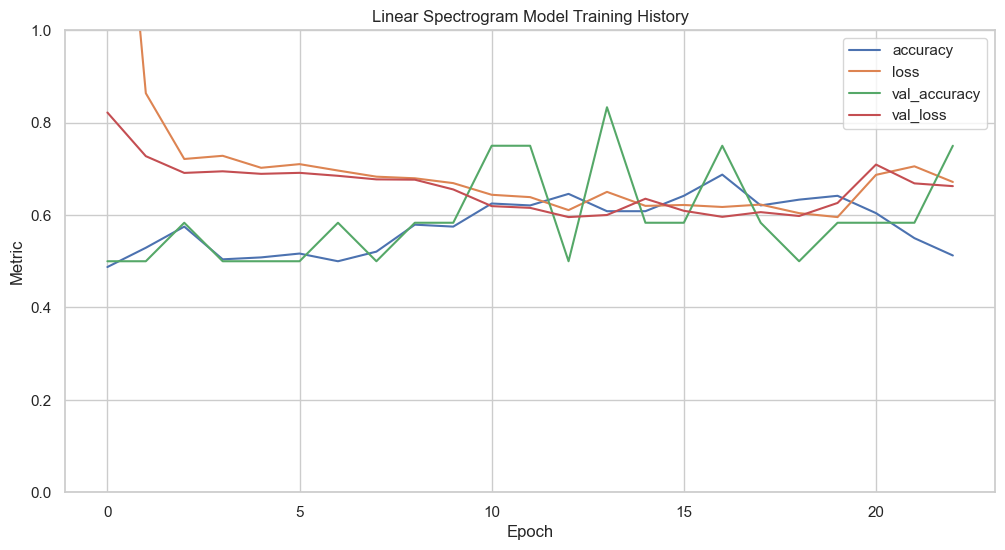

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
\nLinear Spectrogram Model Classification Report:\n
              precision    recall  f1-score   support

        Leak       0.50      0.33      0.40         6
      NoLeak       0.50      0.67      0.57         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12



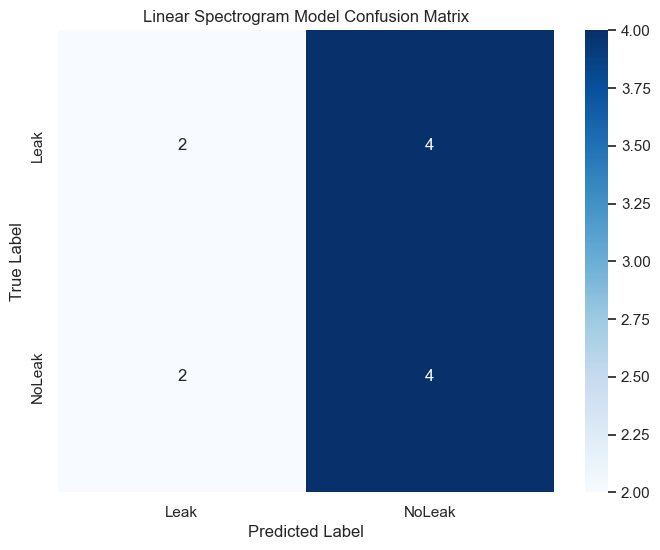

: 

In [ ]:
# Plotting training history
pd.DataFrame(lin_history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Linear Spectrogram Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

# Make predictions
y_pred_probs_lin = lin_model.predict(X_val_lin)
y_pred_lin = (y_pred_probs_lin > 0.5).astype("int32").reshape(-1)

# Generate and print the classification report
print("\\nLinear Spectrogram Model Classification Report:\\n")
print(classification_report(y_val_lin_enc, y_pred_lin, target_names=lin_label_encoder.classes_))

# Generate and plot the confusion matrix
conf_matrix_lin = confusion_matrix(y_val_lin_enc, y_pred_lin)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lin, annot=True, fmt='d',
            xticklabels=lin_label_encoder.classes_,
            yticklabels=lin_label_encoder.classes_,
            cmap='Blues')
plt.title('Linear Spectrogram Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
